# Data Pre-Processing for BERT Pre-Training
### Arnav Bhakta in collaboration with Michael Huang on Album Generation 

In this notebook, I go over the data pre-processing steps that were taking to prepare for the pre-training of our BERT model that we will be using in to encode data. Namely, the pre-training methods that we will be using are Masked Languange Modeling (MLM) and Next Sentence Prediction (NSP). For a brief overview of these methods, MLM gives our BERT model a sentence in which a few tokens are masked, and asks that it returns to us a completed version of the sentence. In doing so, by pre-training BERT on a large corpus of text, we allow it to learn the linguistic patterns and the context of words in sentences, improving its comprehension of the text being used. On the other hand, NSP allows BERT to understand the longer-term dependencies across sentences. It does this by passing BERT 2 sentences and having it decide if it `IsNextSentence` or is `NotNextSentence`. In doing so, BERT is able to learn the stylistic dependencies between sentences and the flow of the text it is being trained on.

Hence, in order to be able to pre-train BERT using these methods, there are several pre-processing steps that we must take, for which the ones that we go over in this notebook, are tokenization and extracting pixel data from images.

## Importing Libraries

We import the below libraries to help us with data pre-processing. `cv2` is the OpenCV python library, that is primarily used in this notebook to load image data from the image files in our dataset. `os` is primarily used for changing and identifying the current directory. `pickle` is primarily used to convert Python objects into byte stream, to store in a file for later use. `matplotlib.pyplot` is used for visualizing and graphing data, to understand its distributions. `tokenize` and `Tokenizer` are primarily used to split up sentences into smaller units or words called tokens, to helping to understand the text and build the model, by making it easier to understand the meaning of the text, by analyzing it as a sequence of words. `pad_sequences` is primarily used to ensure that all sequences in a list have the same length. `numpy` is primarily used for creating arrays and simple arithmetic. `pandas` is primarily used for creating DataFrames. `train_test_split` is primiarily used for splitting up our data into training, testing, and validation sets. `sns` is primarily used for plotting data and making figures.

In [1]:
import cv2
import os
import pickle
import matplotlib.pyplot as plt
import tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

## Fetching Data
In order to start of pre-processing, we must first get our data. To do this, we primarily use `os.listdir` which allows us to fetch the names of the files or directories inside of other directories. We start by setting our initial path to `./dataset`, which is where our entire dataset is housed. We then loop through all of the directories in that folder, where each directory represents an individual album. Upon looping through these directories, we see that each directory contains 2 types of files: `.txt` and `.jpg`. The `.txt` files contain the lyrics of our songs while the `.jpg` files contain the album covers. Hence, we loop through the contents of the directory to first see if any of the names, contain `.jpg`, for which we then record the path to the image. Then, we go through the remaining files to see if the names contain `.txt`, for which if they do, we record the path, open the file, read the lines, and append them to our `lyric_set` list. We also append the corresponding image data of the album cover using `imread()`, which returns a `300x300x3` array, where the `300x300` represents the size of the image, and the `x3` represents the RGB representation of each individual pixel.

In [2]:
lyric_set = []
pixels_set = []
path = "./dataset"
dir_list = os.listdir(path)

for album in dir_list:
    try:
        path_album = "./dataset"
        path_album += str("/" + album)
        dir_album = os.listdir(path_album)
        cover_path = path_album
        for img in dir_album:
            if ".jpg" in img:
                cover_path += "/" + img
        for song in dir_album:
            if ".txt" in song:
                song_path = path_album + "/" + song
                with open(song_path) as song_lyrics:
                    lines = song_lyrics.readlines()
                    lyric_set.append(lines)
                cover_pixels = cv2.imread(cover_path)
                pixels_set.append(cover_pixels)      
    except:
        pass

As each song file indicates each new line with a `\n`, we must remove these characters by removing the last character from each element in `lyric_set`, and removing all empty strings that are remaing as a result of this.

In [3]:
lyric_set = [[lyric[:-1] for lyric in lyrics] for lyrics in lyric_set]
lyric_set = [[lyric for lyric in lyrics if lyric != ''] for lyrics in lyric_set]

Finally, the last step we take in fetching our data, is flattening the `lyric_set` list that contains all of our lyrics to a 1D array, to make the tokenization process easier. We do this by looping through each element or each song in the `lyric_set` list and then looping through each element or lyric in each song, and appending this onto an empty string, seperated by `, `, so that each song is represented as a single string as opposed to a list. Finally, we append this string that now contains the lyrics of a song, onto a new list, `lyric_set_flattened`. Additionally, we remove the last two characters from every element in the `lyric_set_flattened` list, to remove the `, ` that were added to the last lyric of each song.

In [4]:
lyric_set_flattened = []
for ind_song in lyric_set:
    append_song = ""
    for ind_lyric in ind_song:
        append_song += ind_lyric + ", "
    lyric_set_flattened.append(append_song)  
lyric_set_flattened = [lyric[:-2] for lyric in lyric_set_flattened]

In [5]:
lyric_set_flattened[1]

"My mind is full bursting over, With all these things I can't remember, Every little single memory reminds me of you, My eyes were weary with all these tears, You left your shadow in my dreams, And all my doubts seemed to disappear when you came along, Flowers melting up into the sky, Hear my heart where our love collides, We hear the songs we found in the times we lost our way, Gentle memories replace our tears, All the love we had is still right here, We hear the songs we found in the time we lost our way, From without words can not describe, What caused the stars to fall deep inside, Every little single memory reminds me of you, Our days are gone lost forever, Reflecting light glistening under water, Naturally this could be everything that seems so unreal, Flowers melting up into the sky, Hear my heart where our love collides, We hear the songs we found in the time we lost our way, Gentle memories replace our tears, All the love we had is still right here, We hear the songs we found

In [6]:
print(len(pixels_set))
print(len(lyric_set_flattened))

24692
24692


## Tokenization
The next step of our process, is tokenizing our data. We start by creating an array that contains both our `lyric_set_flattened` and `pixels_set` lists. We then shuffle this array in random order, so that when tokenizing and splitting up our dataset into training, testing, and validation sets, there is no specific order in which our data is split up.

In [7]:
seed = 1
np.random.seed = seed
full_set_lyrics = pd.DataFrame()
full_set_lyrics['lyrics'] = lyric_set_flattened
full_set_lyrics['albums'] = pixels_set
full_set_lyrics = full_set_lyrics.to_numpy()
np.random.shuffle(full_set_lyrics)

Subsequently, we split our lyric and image data into training, testing, and validation sets, using the `train_test_split` method. The training set is the set which is used to fit the model and that the model uses to learn patterns in the text. Consequently, the training set, consists of both the text samples and its corresponding labels, such that the model can learn how to properly classify texts. The validation set serves a sort of test set, which we will see soon, to test the accuracy of the model while training on a subset of the data. The test set is usde to test how well the model performs when predicting the labels of text, by providing a set of text samples as inputs, having the model predict the corresponding labels of each sample, and comparing it to the actual labels, which were not provided for testing, but were rather kept to compare how well the predicted labels matched the actual image data.

In splitting up our training, testing, and validation sets, we set our test size to 20% of the dataset, and the validation set to 25% of the training set, which is another 20% of the entire dataset. Accordingly, the training set is 60% of the dataset. We also set our `random_state = 1`, so that we can reproduce the same training, testing, and validation sets every time we run our notebook, as opposed to having them as random subsets everytime.

In [8]:
lyric_data = full_set_lyrics[:, 0]
image_data = full_set_lyrics[:, 1]
lyric_data_train, lyric_data_test, image_data_train, image_data_test = train_test_split(lyric_data, image_data, 
                                                                                        test_size = 0.2, random_state=1)
lyric_data_train, lyric_data_val, image_data_train, image_data_val = train_test_split(lyric_data_train, image_data_train,
                                                                                     test_size = 0.25,  random_state=1)

Next we go ahead and tokenize our data. We do so using `Tokenizer` from `keras`. `Tokenizer` takes in a few parameters, when tokenizing the data, which are as follows: num_words returns the ids of the n most commonly used words in the dataset, where n is the vocab_size we defined as `vocab_size` = 59470, `oov_token` is used to replace out of vocabulary words. We defined the size of our vocabulary by first defining it to be a random value, and the using `tokenizer.word_index`, to see how many words were in our vocabulary. Accordingly, we set this value equal to the our `vocab_size`. We also only based our tokenizer off of our training data, such that we are able to truly test our models accuracy and account for any noise that may be across each of the sets. Post-tokenization, we also called `word_index` from our tokenizer, to get the most commonly used words in our dataset.

In [9]:
vocab_size = 59470
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token= oov_tok)
tokenizer.fit_on_texts(lyric_data_train)
word_index = tokenizer.word_index
display(word_index)

{'<OOV>': 1,
 'the': 2,
 'i': 3,
 'you': 4,
 'and': 5,
 'to': 6,
 'a': 7,
 'me': 8,
 'it': 9,
 'in': 10,
 'my': 11,
 'of': 12,
 'on': 13,
 'your': 14,
 'that': 15,
 "i'm": 16,
 'all': 17,
 'is': 18,
 'we': 19,
 'for': 20,
 'be': 21,
 "don't": 22,
 'so': 23,
 'but': 24,
 'like': 25,
 'with': 26,
 'know': 27,
 'this': 28,
 'up': 29,
 "it's": 30,
 'no': 31,
 'just': 32,
 'what': 33,
 'when': 34,
 'love': 35,
 'oh': 36,
 'chorus': 37,
 'get': 38,
 'got': 39,
 'verse': 40,
 'now': 41,
 'do': 42,
 'out': 43,
 'can': 44,
 'down': 45,
 'if': 46,
 'go': 47,
 'they': 48,
 'was': 49,
 'one': 50,
 "you're": 51,
 'see': 52,
 'are': 53,
 'time': 54,
 'not': 55,
 'never': 56,
 'will': 57,
 'yeah': 58,
 'from': 59,
 'back': 60,
 'want': 61,
 'at': 62,
 'have': 63,
 "can't": 64,
 'she': 65,
 'baby': 66,
 'come': 67,
 'let': 68,
 'take': 69,
 'say': 70,
 'way': 71,
 'make': 72,
 'as': 73,
 'how': 74,
 'he': 75,
 'her': 76,
 'here': 77,
 "i'll": 78,
 'right': 79,
 'there': 80,
 '1': 81,
 '2': 82,
 'away'

In order to be able to train our model using the available texts, we then use the `texts_to_sequences` method to convert our text to a sequence of integers. This is done by using the most frequent words in our `word_index`, and replacing these words with their respective tokens (which are integers) such that the model that we will build is able to interpret the text.

In [11]:
lyric_data_train_tokenized = tokenizer.texts_to_sequences(lyric_data_train)
lyric_data_test_tokenized = tokenizer.texts_to_sequences(lyric_data_test)
lyric_data_val_tokenized = tokenizer.texts_to_sequences(lyric_data_val)

The final step we take in tokenizing our data is padding or truncating all of our sequences, such that they have the same length. This is done, as all neural networks require that inputs have the same size. A popular method of defining a length for which to pad or truncate our sequences to is the `max_length`, however, in this notebook, we instead consider the most frequent length of a sequence and the median length of a sequences. To start, we look at the most frequent length of a sequence. We do this by defining a new list, `len_lyric_set_flattened` and appending on the length of each song to the list. We then loop through the `len_lyric_set_flattened` list and use the `count()` method to see how many times an element of the specified length occurs in the `len_lyric_set_flattened` list and comparing it the `max_lyric_len_count`. If it occurs more frequently, we set the `max_lyric_len_count` to the count we recieved and the `max_lyric_len` to this length.

In [12]:
max_lyric_len = 0
max_lyric_len_count = 0
len_lyric_set_flattened = []

for lyric in lyric_set_flattened:
    len_lyric_set_flattened.append(len(lyric))

for full_lyric_len in len_lyric_set_flattened:
    full_lyric_len_frequency = len_lyric_set_flattened.count(full_lyric_len)
    if full_lyric_len_frequency > max_lyric_len_count:
        max_lyric_len_count = full_lyric_len_frequency
        max_lyric_len = full_lyric_len

By doing so, we see that the most frequent song length is 14 words, which occured 493 times. However, given that there are ~25k songs in our corpus, this is not a great metric to base the length of our padding length to.

In [13]:
print("most frequent song length:", max_lyric_len)
print("count of the most frequent song length:", max_lyric_len_count)

most frequent song length: 14
count of the most frequent song length: 493


Instead, we use the median of these lengths, to get a better understanding of which length most songs are around. We do this by first checking if the number of songs we have is odd or even, and then taking the average of the middle two elements or the middle element, respectively. Accordingly, we see that the median length of our songs is 1114 words, which looking at our histogram, makes more sense, as there is a large number of songs that occur in that range.

In [14]:
len_lyric_set_flattened.sort()
length_lyric_len_set = len(len_lyric_set_flattened)
mid_length = length_lyric_len_set // 2
median_length = 0

if length_lyric_len_set % 2 == 0:
    medR = len_lyric_set_flattened[mid_length]
    medL = len_lyric_set_flattened[mid_length - 1]
    median_length = (medR + medL) / 2
else:
    median_length = len_lyric_set_flattened[mid_length]

print("median song length:", median_length)

median song length: 1114.0


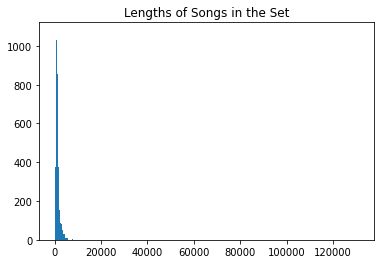

In [15]:
len_lyrics = []
for lyric in lyric_set_flattened:
    len_lyrics.append(len(lyric))

plt.hist(len_lyrics, bins='auto')
plt.title("Lengths of Songs in the Set")
plt.show()

We then pad or truncate the sequences using the `pad_sequences` method, which takes the sequenced text that we just defined, and pads all of the sequences or truncates them to a length of 1140, by adding on 0s until the sequence has a length of 150, or removing integers from the sequence, until the sequence has a length of 1140.

In [16]:
median_length = int(median_length)
lyric_data_train_padded = pad_sequences(lyric_data_train_tokenized, maxlen = median_length, 
                                        padding = 'post', truncating = 'post')
lyric_data_test_padded = pad_sequences(lyric_data_test_tokenized, maxlen = median_length, 
                                        padding = 'post', truncating = 'post')
lyric_data_val_padded = pad_sequences(lyric_data_val_tokenized, maxlen = median_length, 
                                        padding = 'post', truncating = 'post')

The final step in the pre-processing of our text data is combining the training, testing, and validation sets into a single list `lyric_set_flattened_padded`, so that we can export our pre-processed data for later use. We do this by defining an empty list, `lyric_set_flattened_padded` and then using the `extend()` method to add our training, testing, and validation sets to the end of this list, as opposed to the `append()` method which would add our training, testing, and validation sets as seperate columns.

In [17]:
lyric_set_flattened_padded = []
lyric_set_flattened_padded.extend(lyric_data_train_padded)
lyric_set_flattened_padded.extend(lyric_data_test_padded)
lyric_set_flattened_padded.extend(lyric_data_val_padded)

Finally, we create a new list, `full_set`, which contains our text and image data, for exporting.

In [18]:
full_set = [lyric_set_flattened_padded, pixels_set]

We export our data using `pickle` which allows us to export our python object as a byte stream and store it on our disk. To do so, we specify that we will be writing a file via the `w` in a byte stream representation, via the `b`. We then open the `dataset.pkl` file for writing and dump the contents we want into our pickle file, where `full_set` is our content and `f` being the file that we will save to our disk.

In [19]:
with open('dataset.pkl', 'wb') as f:
    pickle.dump(full_set, f)

# NOT FOR ARTIFACT - EXTRA WORK

In the pre-processing of our image data, the last step we take is resizing our images, such that they are `120x120` isntead of `300x300`. We do this useing `cv2.resize()`, which takes in several parameters: the image we want to reshape as the `src` parameter and the dimensions of the reshaped image as a tuple for the `dsize` parameter.

In [228]:
scale_pct = 40
for img_resize in pixels_set:
    try:
        wdth = int(img_resize.shape[0] * scale_pct / 100)
        hgt = int(img_resize.shape[1] * scale_pct / 100)
        dim = (wdth, hgt)
        img_resize = cv2.resize(img_resize, dim)
        # I have not used imwrite() yet, as based on the model we are using, it may or may not be necessary to reshape the data
    except:
        pass